About Data:
- each row contains one player's post-game stats
- create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)

Column Descriptions: 
- DBNOs - Number of enemy players knocked.
- assists - Number of enemy players this player damaged that were killed by teammates.
- boosts - Number of boost items used.
- damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
- headshotKills - Number of enemy players killed with headshots.
- heals - Number of healing items used.
- Id - Player’s Id
- killPlace - Ranking in match of number of enemy players killed.
- killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- killStreaks - Max number of enemy players killed in a short amount of time.
- kills - Number of enemy players killed.
- longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- matchDuration - Duration of match in seconds.
- matchId - ID to identify match. There are no matches that are in both the training and testing set.
- matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- revives - Number of times this player revived teammates.
- rideDistance - Total distance traveled in vehicles measured in meters.
- roadKills - Number of kills while in a vehicle.
- swimDistance - Total distance traveled by swimming measured in meters.
- teamKills - Number of times this player killed a teammate.
- vehicleDestroys - Number of vehicles destroyed.
- walkDistance - Total distance traveled on foot measured in meters.
- weaponsAcquired - Number of weapons picked up.
- winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- numGroups - Number of groups we have data for in the match.
- maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [167]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from dask import dataframe as dd

While Pandas is perfect for small to medium-sized datasets, larger ones are problematic. we can see that running the above cell takes a long time to run.

we can deal with this using Pandas together with Dask for parallel computing.

- One solution would be to limit the data to a smaller subset, dealing with data for each subsequent subset. while in some cases, that might be a sufficient solution, it does lead to a ruther redundant workflow, and it far from being the most effective solution.
- The most common fix is using Pandas alongside another solution — like a relational SQL database, MongoDB, ElasticSearch, or something similar.
- another approach using Pandas and another handy open-source Python library, Dask, to deal with larger-than-memory datasets. this solution fits our case perfectly.
    - this is the approach used

Dask is tightly integrated with NumPy and provides Pandas with dataframe-equivalent structures — the **dask.dataframes** — that are based on lazy loading and can be used to perform dataframe operations in chunks and in parallel. it scales to datasets much larger than memory.

**#1** The very first memory optimization step is specifying the columns data types during the import (via the dtype= input parameter). That way, we can force Pandas to convert some values into types with a significantly lower memory footprint.

In [206]:
dfd = dd.read_csv(
    '../Data/raw_data/train_V2.csv', 
    delimiter=',',
    blocksize=32000000 # = 32 Mb chunks = 32 * 10^6 bytes
)

**NOTES**
- this is a “blocked parallel” DataFrame object that looks and feels like the pandas API, but for parallel and distributed workflows.
- comprised of many in-memory pandas DataFrames separated along the index. split into 32Mb chunks
- this allows us to perform operations on a Dask DataFrame that correspondingly triggers many pandas operations on the constituent pandas DataFrames.
    - in a way that is mindful of potential parallelism and memory constraints.

In [6]:
# solving error ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables 
#are on your systems' PATH'

# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

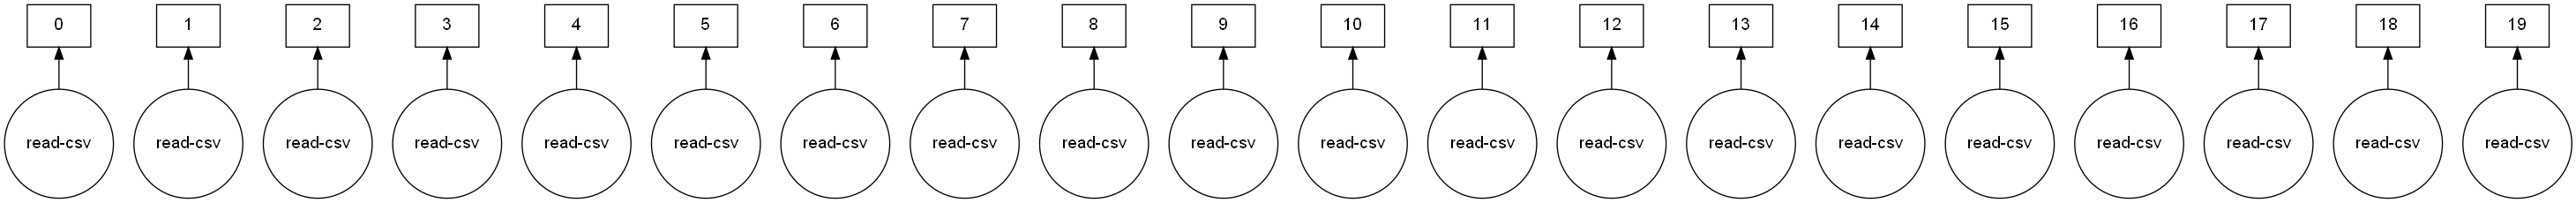

In [57]:
dfd.visualize()

**NOTE** dask's 'read_csv' method is pretty similar to the Pandas one, except here we specify the byte-size per chunks

the result is a Dask delayed dataframe object, which won’t do any calculations yet. We can launch it to be computed via the .compute() method.


**NOTE** to prevent our memory from being clogged, it can be saved it directly to hard drive

In [32]:
def store_as_result(df, fn='file.h5'):
    store = pd.HDFStore('../Data/result_store/{}'.format(fn))
    store.put('df',
           df.compute(),
           format='table',
           data_columns=True)

# 1- Exploratory Data Analysis

### 1.1 general data overview

In [96]:
dfd.head(5).T

,0,1,2,3,4
Id,7f96b2f878858a,eef90569b9d03c,1eaf90ac73de72,4616d365dd2853,315c96c26c9aac
groupId,4d4b580de459be,684d5656442f9e,6a4a42c3245a74,a930a9c79cd721,de04010b3458dd
matchId,a10357fd1a4a91,aeb375fc57110c,110163d8bb94ae,f1f1f4ef412d7e,6dc8ff871e21e6
assists,0,0,1,0,0
boosts,0,0,0,0,0
damageDealt,0.0,91.47,68.0,32.9,100.0
DBNOs,0,0,0,0,0
headshotKills,0,0,0,0,0
heals,0,0,0,0,0
killPlace,60,57,47,75,45


In [97]:
dfd.compute().shape

(4446966, 29)

In [98]:
dfd.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [99]:
dfd.dtypes

Id                  object
groupId             object
matchId             object
assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
maxPlace             int64
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
winPlacePerc       float64
dtype: object

### 1.2 descriptive statistics

In [70]:
dfd.describe().compute().T

,count,mean,std,min,25%,50%,75%,max
assists,4446966.0,0.233815,0.588573,0.0,0.0,0.0000,0.0000,22.0
boosts,4446966.0,1.106908,1.715794,0.0,0.0,0.0000,2.0000,33.0
damageDealt,4446966.0,130.717138,170.780621,0.0,0.0,85.0000,187.8000,6616.0
DBNOs,4446966.0,0.657876,1.145743,0.0,0.0,0.0000,1.0000,53.0
headshotKills,4446966.0,0.226820,0.602155,0.0,0.0,0.0000,0.0000,64.0
heals,4446966.0,1.370147,2.679982,0.0,0.0,0.0000,2.0000,80.0
killPlace,4446966.0,47.599350,27.462937,1.0,24.0,48.0000,71.0000,101.0
killPoints,4446966.0,505.006042,627.504896,0.0,0.0,0.0000,1175.0000,2170.0
kills,4446966.0,0.924783,1.558445,0.0,0.0,0.0000,1.0000,72.0
killStreaks,4446966.0,0.543955,0.710972,0.0,0.0,0.0000,1.0000,20.0


In [100]:
dfd.describe(include='object').compute()

,Id,groupId,matchId,matchType
unique,4446966,2026745,47965,16
count,4446966,4446966,4446966,4446966
top,00000160737ebf,14d6b54cdec6bc,07fabe4f871aa4,squad-fpp
freq,1,74,100,1756186


### 1.3 Null values

In [72]:
dfd.isnull().sum().compute()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [84]:
dfd_mv_rows = dfd[dfd['winPlacePerc'].isna()]
dfd_mv_rows.compute()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
76439,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [78]:
dfd_mv_rows = dfd.compute()[dfd_mv]
dfd_mv_rows

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
76439,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [67]:
# dfd_mv = dfd['winPlacePerc'].isna().compute()
# # dfd_mv = dfd[dfd.isna().compute()].compute()
# # dfd_mv

dfd_mv = data['winPlacePerc'].isna()
data[dfd_mv]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
76439,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


### 1.4 duplicate values

In [92]:
duplicates = dfd.compute()[dfd.compute().duplicated()]
print(f'number of duplicate values: {duplicates.shape[0]}')

number of duplicate values: 0


### 1.5 numeric data distributions

In [211]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_data = dfd.select_dtypes(include=numerics)
num_data.compute()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.00,0,0,0,60,1241,0,0,...,0,0.0000,0,0.000,0,0,244.80,1,1466,0.4444
1,0,0,91.47,0,0,0,57,0,0,0,...,0,0.0045,0,11.040,0,0,1434.00,5,0,0.6400
2,1,0,68.00,0,0,0,47,0,0,0,...,0,0.0000,0,0.000,0,0,161.80,2,0,0.7755
3,0,0,32.90,0,0,0,75,0,0,0,...,0,0.0000,0,0.000,0,0,202.70,3,0,0.1667
4,0,0,100.00,0,0,0,45,0,1,1,...,0,0.0000,0,0.000,0,0,49.75,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222359,0,0,0.00,0,0,0,74,1029,0,0,...,0,1292.0000,0,0.000,0,0,1019.00,3,1507,0.1786
222360,0,1,44.15,0,0,0,69,0,0,0,...,0,0.0000,0,0.000,0,0,81.70,6,0,0.2935
222361,0,0,59.06,0,0,0,66,0,0,0,...,0,0.0000,0,2.184,0,0,788.70,4,0,0.4815
222362,0,4,180.40,1,1,2,11,0,2,1,...,2,0.0000,0,0.000,0,0,2748.00,8,0,0.8000


note: distplot and boxplots

In [103]:
num_data.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.00,0,0,0,60,1241,0,0,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,0,0,91.47,0,0,0,57,0,0,0,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1,0,68.00,0,0,0,47,0,0,0,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,0,0,32.90,0,0,0,75,0,0,0,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,0,0,100.00,0,0,0,45,0,1,1,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


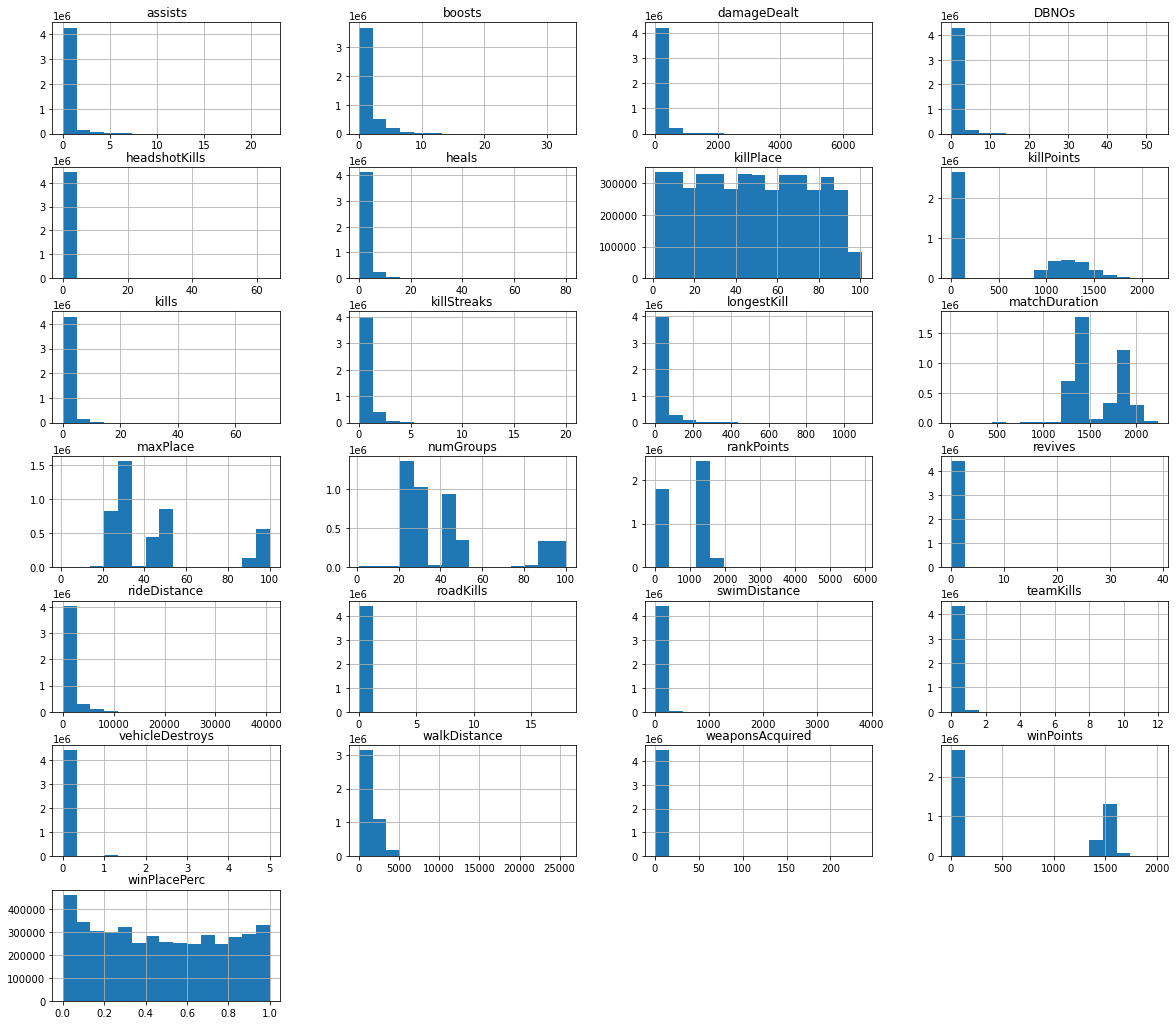

In [108]:
num_data.hist(bins=15, figsize=(20, 18), layout=(7, 4))
plt.title('Data Distributinos')
plt.show()

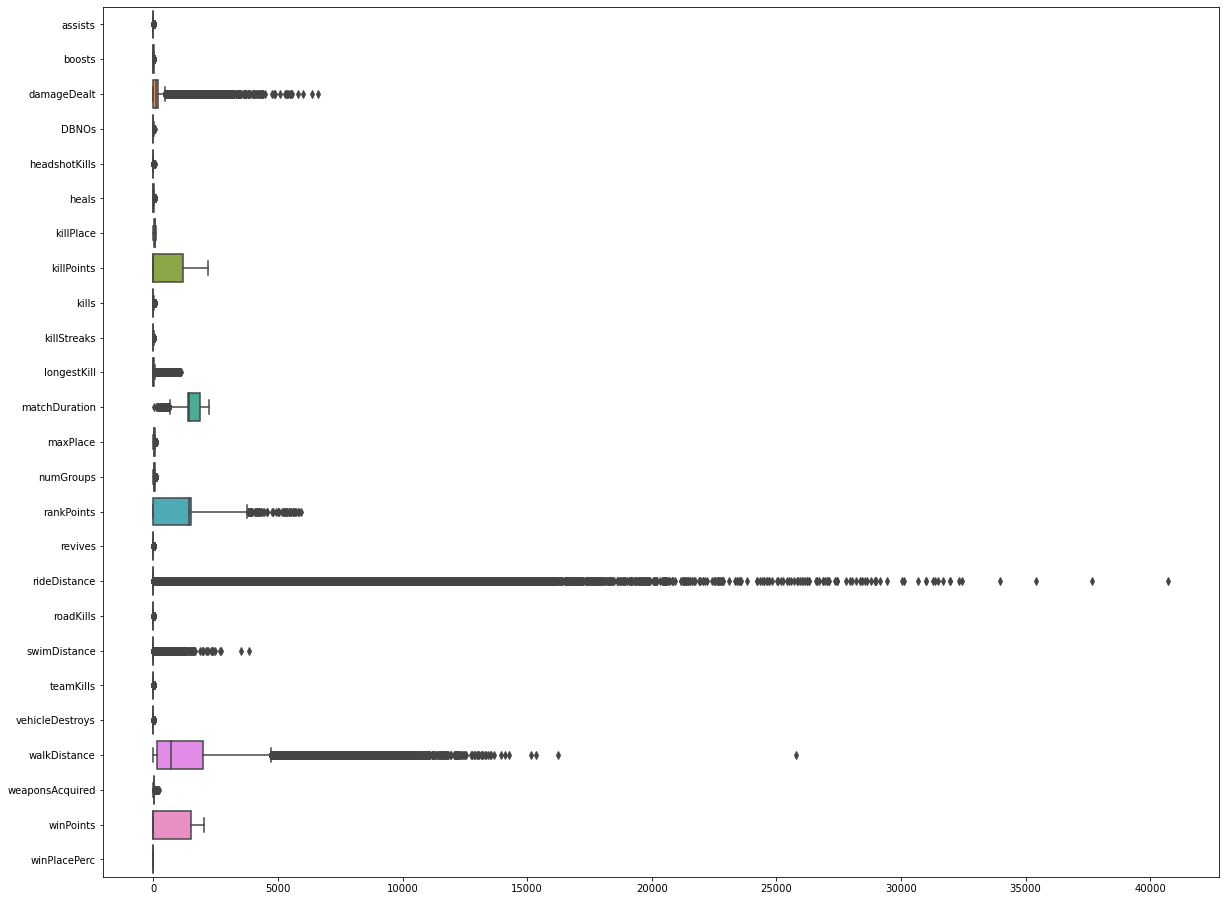

In [109]:
# Original Dataframe
plt.figure(figsize=(20,16))
sns.boxplot(data=num_data, orient='h')
plt.show()

### 1.6 correlations

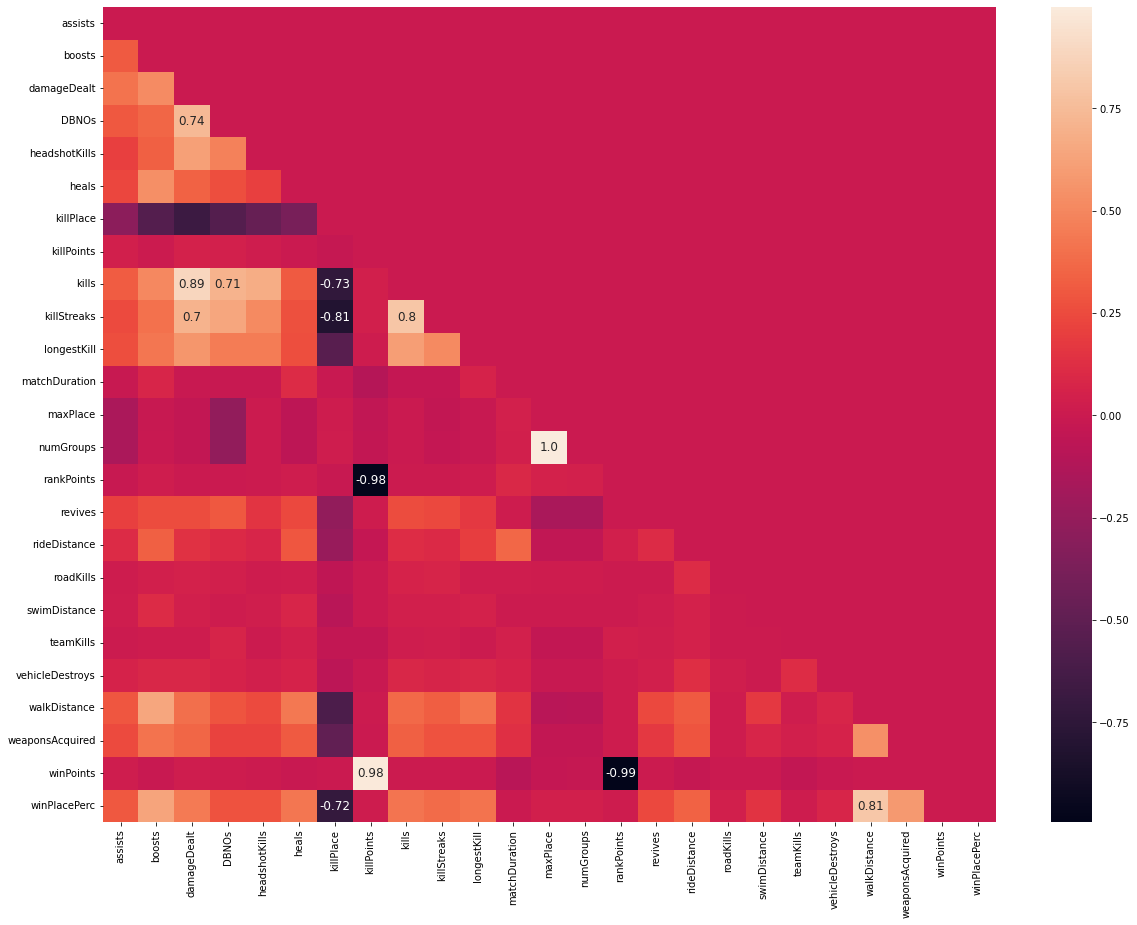

In [124]:
# The correlation matrix
corr_mat = num_data.corr()

# Strip out the diagonal values for the next step
for x in range(len(list(num_data.columns))):
    corr_mat.iloc[0:x+1,x] = 0.0

labels = corr_mat.applymap(lambda v: str(round(v, 2)) if abs(v) > 0.7 else '')  

plt.subplots(figsize=(20,15))
sns.heatmap(corr_mat, annot=labels, annot_kws={'fontsize':12}, fmt='')
plt.show()

**is negative correlation meaningless?**

In [125]:
# Pairwise maximal correlations
print('--> highest correlated pairs')
pair_corr = pd.DataFrame()
pair_corr['col1'] = corr_mat.abs().idxmax()
pair_corr['col2'] = corr_mat.abs().idxmax().index
pair_corr['corr_score'] = corr_mat.abs().max()
# display(pair_corr[pair_corr['corr_score'] > 0.50])
display(pair_corr[pair_corr['corr_score'] > 0.70])

--> highest correlated pairs


,col1,col2,corr_score
damageDealt,kills,damageDealt,0.888783
DBNOs,kills,DBNOs,0.707848
killPlace,killStreaks,killPlace,0.810516
killPoints,winPoints,killPoints,0.983417
kills,killStreaks,kills,0.802500
maxPlace,numGroups,maxPlace,0.997900
rankPoints,winPoints,rankPoints,0.993845
walkDistance,winPlacePerc,walkDistance,0.810888


### 1.7 categorical data distributions

In [207]:
cate_data = dfd.select_dtypes(exclude=numerics)
cate_cols = cate_data.compute().columns
cate_data.compute().head()

,Id,groupId,matchId,matchType
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,squad-fpp
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,squad-fpp
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,duo
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,squad-fpp
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,solo-fpp


In [208]:
# id value counts
vcs = cate_data.compute()['Id'].value_counts()
vcs[vcs > 1]

Series([], Name: Id, dtype: int64)

**NOTE** not worth encoding 

In [131]:
# id value counts
vcs = cate_data['groupId'].value_counts()
vcs[vcs > 1]

14d6b54cdec6bc    74
b8275198faa03b    72
128b07271aa012    64
7385e5fe214021    49
e52a2e6ca30474    36
                  ..
ec569499824179     2
5f943c804281ce     2
ecf8d84c8a1d8f     2
7eb9858cbb8d02     2
0c8e2dce576917     2
Name: groupId, Length: 1234468, dtype: int64

**NOTE** worth encoding

In [132]:
# id value counts
vcs = cate_data['matchId'].value_counts()
vcs[vcs > 1]

4b5db40aec4797    100
b10e8738adafb9    100
bc28c54250342d    100
c2db47653f79b7    100
79e05d7908e0ca    100
                 ... 
da121c891ea777      7
39d2800dad8ae6      6
9f2b49358564ea      6
8aa5066c4b6a79      5
e5a77433bc436f      2
Name: matchId, Length: 47964, dtype: int64

**NOTE** worth encoding

In [133]:
# id value counts
vcs = cate_data['matchType'].value_counts()
vcs[vcs > 1]

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536762
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

**NOTE** worth encoding

In [136]:
for col in cate_data.columns:
    unique_vals = cate_data[col].nunique()
    print(f'feature ({col}): {unique_vals} unique values')

feature (Id): 4446966 unique values
feature (groupId): 2026745 unique values
feature (matchId): 47965 unique values
feature (matchType): 16 unique values


We're going to show values by matchType, as knowing distribution of games by their types might provide with valuable information. we're not going to show for ID features(Id, groupId, matchId) as that only shows the uniqueness of each group, entity, or match, and checking their distributions does not indicate any further useful insight.

In [153]:
# mt: match type
print(f"Match Types in the data:")

match_types = cate_data['matchType'].unique().tolist()
for i, mt in enumerate(match_types):
    print(f" {i+1}- {mt}")

Match Types in the data:
 1- squad-fpp
 2- duo
 3- solo-fpp
 4- squad
 5- duo-fpp
 6- solo
 7- normal-squad-fpp
 8- crashfpp
 9- flaretpp
 10- normal-solo-fpp
 11- flarefpp
 12- normal-duo-fpp
 13- normal-duo
 14- normal-squad
 15- crashtpp
 16- normal-solo


In [173]:
match_types_agg = cate_data.groupby(['matchType']).count()[['Id']].reset_index()
match_types_agg

,matchType,Id
0,crashfpp,6287
1,crashtpp,371
2,duo,313591
3,duo-fpp,996691
4,flarefpp,718
5,flaretpp,2505
6,normal-duo,199
7,normal-duo-fpp,5489
8,normal-solo,326
9,normal-solo-fpp,1682


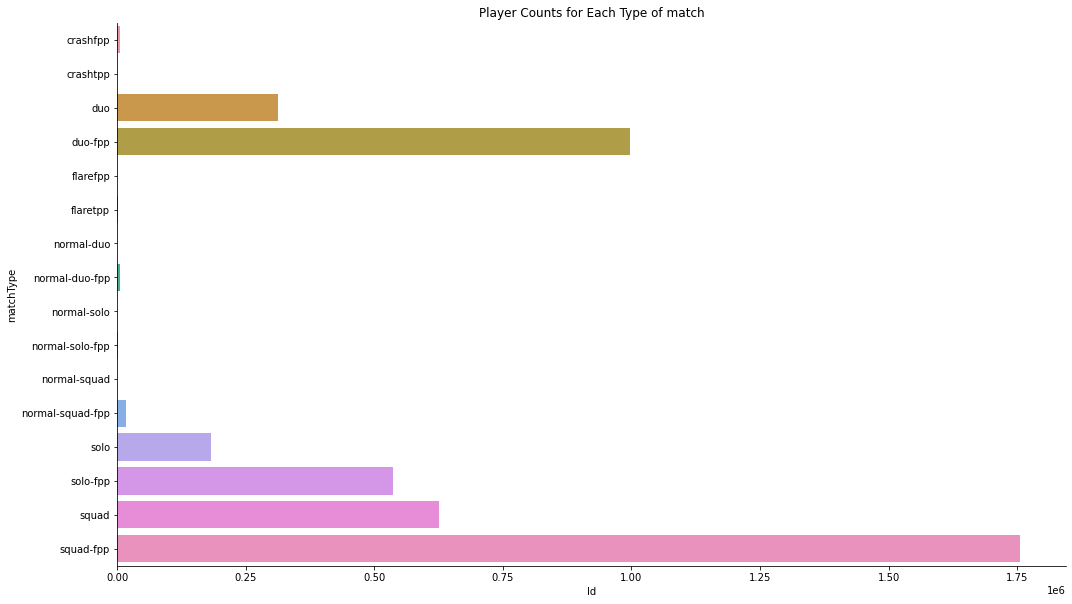

In [219]:
# visualization showing distrubtion across category features
sns.catplot(data=match_types_agg, y='matchType', x='Id', kind='bar', ci=None, height=8.27, aspect=15/8.27)
plt.title('Player Counts for Each Type of match')
plt.show()

**LATER** adjust axis x-axis values turn from 1.5le6 to 1.5000000 (change to log scale?)

# 2- Preprocessing and Cleaning

## 2.1 Data Cleaning

since the number of rows with missing values is only 1, we can remove that row since its represents very insignificant portion of the information lost from the data, as the data is over 4 million records.

In [196]:
from scipy.stats import skew, kurtosis

### 2.1.1 Null Values

In [193]:
missing_row = dfd_mv_rows.compute()
missing_row_index = missing_row_index[0]
missing_row_index

76439

In [194]:
dfd_cle_pt1 = dfd.compute().drop([missing_row_index])

In [199]:
# RR: rows removed
dfd_cle_pt1.to_csv('../Data/processed/train_V2_RR.csv')

### 2.1.2 Data Skewness

In [200]:
dfd_cle_pt1 = dd.read_csv(
    '../Data/processed/train_V2_RR.csv', 
    delimiter=',',
    blocksize=32000000 # = 32 Mb chunks = 32 * 10^6 bytes
)

In [217]:
skew_df = pd.DataFrame(index=num_data.columns)
numeric_columns = num_data.columns
# dfd_cle_pt1_num = dfd_cle_pt1[numeric_columns]

# Caculate Skewness 
skew_df['Skew'] = skew(dfd_cle_pt1[numeric_columns], axis=0, bias=True) 
# Calculate the kurtosis
skew_df['Kurtosis'] = kurtosis(dfd_cle_pt1[numeric_columns], axis=0, bias=True) 

display(skew_df)

,Skew,Kurtosis
assists,3.567568,21.230431
boosts,1.949955,4.299421
damageDealt,2.958918,20.112836
DBNOs,3.201535,22.830901
headshotKills,5.218254,106.213251
heals,3.444342,18.699235
killPlace,0.026425,-1.184336
killPoints,0.519117,-1.561420
kills,3.362903,27.438684
killStreaks,1.252572,2.115789


# 2- Analysis

In [175]:
# how many players in average match?
avg_player_per_match = round(cate_data.groupby(['matchId']).count()['Id'].mean())
print(f'average number of players in one match: {avg_player_per_match}')

average number of players in one match: 93


In [176]:
# how many players per group on average?
avg_player_per_group= round(cate_data.groupby(['groupId']).count()['Id'].mean())
print(f'average number of players in each group: {avg_player_per_group}')

average number of players in each group: 2


In [172]:
# what is the player group number with the highest frequency?
cate_

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

# References

- https://towardsdatascience.com/how-to-handle-large-datasets-in-python-with-pandas-and-dask-34f43a897d55
- https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15
- https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft
- https://tutorial.dask.org/01_dataframe.html
- https://stackabuse.com/ultimate-guide-to-heatmaps-in-seaborn-with-python/